In [1]:
# !pip install pygame

In [2]:
# import warnings
# warnings.filterwarnings("ignore")
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# import cv2
# cap1 = cv2.VideoCapture(0)
# cap2 = cv2.VideoCapture(1)
# cv2.namedWindow('Webcam 1')
# cv2.namedWindow('Webcam 2')
    
# while True:
#     ret1, frame1 = cap1.read()
#     ret2, frame2 = cap2.read()
#     cv2.imshow('Webcam 1', frame1)
#     cv2.imshow('Webcam 2', frame2)
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# # Release the webcams and destroy all windows
# cap1.release()
# cap2.release()
# cv2.destroyAllWindows()

In [4]:
import numpy as np
import cv2
import random
import pygame
import pickle

def init_cameras(id1=0, id2=1):
    '''Инициализация и возврат 2х камер'''
    cap1 = cv2.VideoCapture(id1)
    cap2 = cv2.VideoCapture(id2)
    cv2.namedWindow('Webcam 1')
    cv2.namedWindow('Webcam 2')
    return cap1, cap2
    
def get_frame():
    '''Функция захвата фреймов с 2х камер, предполагает, что устройства уже открыты глобально'''
    ret1, frame1 = cap1.read()
    ret2, frame2 = cap2.read()
    cv2.imshow('Webcam 1', frame1)
    cv2.imshow('Webcam 2', frame2)
    return (frame1, frame2)

def setup_pygame(width, heigth):
    '''Инииализация и возврат экрана'''
    pygame.init()
    screen = pygame.display.set_mode((0, 0), pygame.FULLSCREEN)
    screen.fill((255, 255, 255))  # white
    return screen

def create_points(n_points, window_width, window_heigth):
    '''Функция создания точек по периметру экрана, между которыми будет бегать курсор 
    в количестве n_points на каждой из сторон экрана, порядок точек образует как бы 2 змейки'''
    points = [] 
    x1 = np.linspace(0, window_width, n_points, dtype = 'int') #как линейное пространство от 0 до 
    y1 = np.array([0, window_heigth]*(n_points//2)) #максимальной ширины в количестве n_points
    x2 = np.array([0, window_width]*(n_points//2))
    y2 = np.linspace(window_heigth, 0, n_points, dtype = 'int')
    points = list(zip(np.append(x1,x2), np.append(y1,y2)))

    return points

def move_to_points(screen, list_of_points, n, speed = 9999, capture = True):
    '''Функция генерации данных, принимает на вход pygame.screen, список крайних точек между которыми
    она добавит промежуточные точки в количестве n, speed - скорость перехода между точками, флаг 
    capture указывает на то нужно ли сохранять захваты с камер. Функция предполагает что если capture = True
    то глобально уже существуют два устройства opencv: cap1 и cap2, которые через фунцию get_frame вернут
    2 изображения, которые будут сохранены как соответствующие записи в результирующем списке. Таким же
    образом будут сохранены координаты курсора. '''    
    data = [] # Результат работы функции накапливается здесь
    clock = pygame.time.Clock() #Часы для задания скорости
    for ((sx, sy),(ex,ey)) in zip(list_of_points[:-1], #Берем координаты текущей и 
                                  list_of_points[1:]): #следующей точки
        for x, y in zip(np.linspace(sx, ex, n, dtype='int'), #Бежим по промежуточным координатам
                        np.linspace(sy, ey, n, dtype='int')):#
            
            for event in pygame.event.get(): #Для прерывания цикла кнопкой q
                if event.type == pygame.QUIT or (event.type == pygame.KEYDOWN and event.key == pygame.K_q):
                    pygame.quit()

            screen.fill((255, 255, 255)) #Заливаем экран       
            pygame.draw.circle(screen, (0, 0, 0), [x,y], 5)   #Рисуем курсор в виде черного кружка в текущих координатах        
            clock.tick(speed) #Скорость            
            pygame.display.update() #Обновляем экран          
    
            if capture: #Делаем захват с камер, если нужно
                frame1, frame2 = get_frame()
            else:
                frame1, frame2 = [],[]
            data.append({'x':x, 'y':y, 'camera1':frame1, 'camera2':frame2}) #Делаем текущую запись
    pygame.quit()  #Закрываем экран   
    return data

pygame 2.3.0 (SDL 2.24.2, Python 3.10.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [5]:
n_points = 8
WINDOW_WIDTH = 1920
WINDOW_HEIGTH = 1080

In [6]:
# points = create_points(n_points, WINDOW_WIDTH, WINDOW_HEIGTH)
# screen = setup_pygame(WINDOW_WIDTH,WINDOW_HEIGTH)

# cap1, cap2 = init_cameras()
# input()
# data = move_to_points(screen, points, n=128, capture=True)

In [7]:
# with open('frames.pickle', 'wb') as handle:
#     pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
with open('frames2.pickle', 'rb') as handle:
        data = pickle.load(handle)    

(779, 93)


<Figure size 640x480 with 0 Axes>

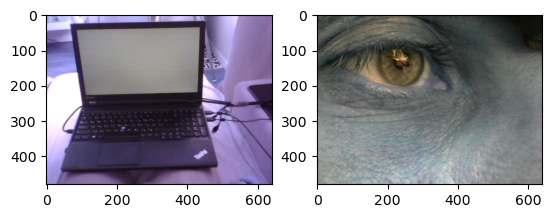

In [9]:
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import random
item = random.choice(data)
img1, img2, x, y = item['camera1'], item['camera2'], item['x'], item['y']

plt.figure()
f, axis = plt.subplots(1,2)
print((int(x),int(y)))
# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axis[0].imshow(img1)
axis[1].imshow(img2)


In [12]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch
import torchvision.models as models
from torch import nn
from tqdm.notebook import tqdm
from torch.cuda.amp import autocast

VAL_TEST_RATIO = 0.5
TRAIN_VALTEST_RATIO = 0.7

class EyeDataset(Dataset):
    def __init__(self, data, transform=None, target_transform=None):
        self.data = data
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        camera1 = self.data[idx]['camera1']
        camera2 = self.data[idx]['camera2']
        x = self.data[idx]['x']
        y = self.data[idx]['y']
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return camera1, camera2, x, y

def collate_batch(batch):
    camera1, camera2, x, y = [],[],[],[]
    for _data in batch:    
#         print(_data)
        camera1.append(_data[0]/256)
        camera2.append(_data[1]/256)
        x.append(_data[2]/WINDOW_WIDTH)
        y.append(_data[3]/WINDOW_HEIGTH)       
    camera1, camera2, x, y = np.array(camera1), np.array(camera2), np.array(x), np.array(y)
    return torch.FloatTensor(camera1), torch.FloatTensor(camera2), x, y
    

train_records, val_test_records = train_test_split(data, train_size=TRAIN_VALTEST_RATIO, 
                                             random_state=42)
val_records, test_records = train_test_split(val_test_records, train_size=VAL_TEST_RATIO, 
                                             random_state=42)

In [13]:
len(train_records), len(val_records), len(test_records)

(2777, 595, 596)

In [14]:
train_dataset, val_dataset, test_dataset = EyeDataset(train_records), EyeDataset(val_records), EyeDataset(test_records)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_batch)

In [15]:
%%timeit
next(iter(train_loader))

83.2 ms ± 3.83 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
vgg11_1 = models.vgg11(pretrained=True)
vgg11_2 = models.vgg11(pretrained=True)
precls_out = 8

/home/ilja/anaconda3/envs/a400/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ilja/anaconda3/envs/a400/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
for i in [5,5]:
    del (vgg11_1.classifier[i])
    del (vgg11_2.classifier[i])

vgg11_1.classifier[3]= nn.Linear(4096, precls_out)
vgg11_2.classifier[3]= nn.Linear(4096, precls_out)

In [18]:
class EyeTracker(nn.Module):
    def __init__(self, precls_out):
        super(EyeTracker, self).__init__()
        self.vgg1 = vgg11_1
        self.vgg2 = vgg11_2
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(precls_out*2, precls_out)
        self.fc2 = nn.Linear(precls_out, 2)
        self.activ = nn.ReLU()

    def forward(self, image1, image2):
        out1 = self.vgg1(image1)
        out2 = self.vgg1(image2)
        out = torch.cat((out1, out2),dim=1)
        out = self.fc1(out)
        out = self.activ(out)
        out = self.fc2(out)       
        return out   



In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EyeTracker(8).to(device)

In [20]:
%%time
from torch.optim import Adam, AdamW

EPOCHS = 10
lr_cnn = 1e-5
lr_cls = 1e-3

criterion = nn.MSELoss()

optimizer_cnn = Adam([
    {'params': model.vgg1.features.parameters()},
    {'params': model.vgg2.features.parameters()}], lr = lr_cnn)

optimizer_cls = Adam([
    {'params': model.vgg1.classifier.parameters()},
    {'params': model.vgg2.classifier.parameters()},
    {'params': model.fc1.parameters()},
    {'params': model.fc2.parameters()}], lr = lr_cls)


train_history = []
val_history = []
best_loss = 5

for epoch in range(EPOCHS):
    model.train()
    pbar = tqdm(train_loader)
    for batch in pbar:
        optimizer_cnn.zero_grad()           
        optimizer_cls.zero_grad()     
        
        image1, image2, x, y = batch
        image1 = image1.permute(0,3,2,1).to(device)
        image2 = image2.permute(0,3,2,1).to(device)
        out = model(image1, image2)
        target = torch.Tensor(np.concatenate([[x], [y]], axis = 0)).permute(1,0).to(device)
        loss = criterion(out, target)
        loss.backward()
        
        optimizer_cnn.step()        
        optimizer_cls.step()  
        
        train_history.append(loss.detach().cpu().numpy())  
        pbar.set_description(f'''Train Loss: {train_history[-1]:.2f}, 
                             emb_lr: {optimizer_cnn.param_groups[0]['lr']:.2E},
                             cls_lr: {optimizer_cls.param_groups[0]['lr']:.2E}''')  
        
    '''Валидация'''
    model.eval()
    cum_val_loss = 0 
    with torch.no_grad():
        for batch in val_loader:
            image1, image2, x, y = batch
            image1 = image1.permute(0,3,2,1).to(device)
            image2 = image2.permute(0,3,2,1).to(device)
            out = model(image1, image2)
            target = torch.Tensor(np.concatenate([[x], [y]], axis = 0)).permute(1,0).to(device)
            val_loss = criterion(out, target).cpu().item()
            cum_val_loss += val_loss
    cum_val_loss = np.mean(cum_val_loss)        

    print(f'Val_loss: {cum_val_loss:.3f} Train loss: {loss:.3f}\n') 
        
      

  0%|          | 0/348 [00:00<?, ?it/s]

Val_loss: 0.551 Train loss: 0.015



  0%|          | 0/348 [00:00<?, ?it/s]

Val_loss: 0.334 Train loss: 0.003



  0%|          | 0/348 [00:00<?, ?it/s]

Val_loss: 0.165 Train loss: 0.003



  0%|          | 0/348 [00:00<?, ?it/s]

Val_loss: 0.187 Train loss: 0.001



  0%|          | 0/348 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
from scipy.ndimage.filters import gaussian_filter1d
def plot_history(train_history, val_history):
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(gaussian_filter1d(train_history, sigma=1), label='Train loss')
    ax.plot(gaussian_filter1d(val_history, sigma=1), label='Validation loss')
    ax.set_xlabel('Batch')
    ax.set_ylabel('Loss')
    ax.legend()
    plt.show()
    
plot_history(train_history, val_history)

In [ ]:
x.shape


In [ ]:
torch.Tensor(np.concatenate([[x], [y]], axis = 0)).permute(1,0).shape